
# Here we provide a jupyter notebook to reproduce results showed in the article more specifically here Fig.S3

In [17]:
from incidence_model import *
import matplotlib.pyplot as pyplot
import numpy as np
import matplotlib.patches as patches
import time
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as plticker
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import math

In [2]:
import ray
ray.init()

2021-09-28 23:32:41,889	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.9',
 'raylet_ip_address': '192.168.1.9',
 'redis_address': '192.168.1.9:6379',
 'object_store_address': 'tcp://127.0.0.1:54075',
 'raylet_socket_name': 'tcp://127.0.0.1:56027',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\MAXIMUS\\AppData\\Local\\Temp\\ray\\session_2021-09-28_23-32-40_478628_3580',
 'metrics_export_port': 55824,
 'node_id': '11b573c460d7cefab861e32efc44d150ed79178449e3353d5c378d7b'}

In [7]:
incidence_value = 1e-2

In [4]:
@ray.remote
def drift_bar(mu,N,N0,s_scheme,s,incidence=incidence_value):
    gamma_scan = arange(2,4,1/20.)
    nopt=np.log2(N/N0)
    for n in arange(2,nopt+1):
        
            P_scan = array([Pis(mu,n,s,gamma,[0,N/N0],s_scheme)[-1] for gamma in gamma_scan ] )   # calculate the probabilities for a given schema (etc. scd)
            
            P_min = np.min(P_scan) # obtain minimum probability

            i_min = np.argmin(P_scan) # index value corresponding to the minimum probability

            gamma_min = gamma_scan[i_min]  # obtain the vlaue of the amplification factor where the probability os minimized 

            if P_min < incidence/N0:
                return {"n":n, "gamma":gamma_min, "d":int(math.ceil(1.0/(gamma_min-1.0)/s)), "r0":(gamma_min**(1.0-n))*N/N0/365.}  
    return {"n":-1, "gamma":-1, "d":-1, "r0":-1}

### Define the resolution of heatmaps (dim: RESXRES)

In [15]:
# the original resolution in the article (if you modify it there will be an error if you plot the original files)
RES=300

In [16]:
# define custom colormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([256/256, 256/256, 256/256, 1])
black = np.array([0/256, 0/256, 0/256, 1])
newcolors[:1, :] = white
#cf. https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html


In [10]:

def DataGeneratorMuN(X1,X2,Y1,Y2,s,N01,N02):

    time_s = time.time()

    points=[]
    for mu in Y1:
        for N in X1:
            points+=[drift_bar.remote(mu,N,N01,"scd",s)]
    points = ray.get(points)

    n_points=[]
    for mu in Y1:
        for N in X1:
            n_points+=[drift_bar.remote(mu,N,N01,"neutral",s)]
    n_points = ray.get(n_points)

    p_1, n_p_1 = points,n_points


    points=[]
    for mu in Y2:
        for N in X2:
            points+=[drift_bar.remote(mu,N,N02,"scd",s)]
    points = ray.get(points)

    n_points=[]
    for mu in Y2:
        for N in X2:
            n_points+=[drift_bar.remote(mu,N,N02,"neutral",s)]
    n_points = ray.get(n_points)

    p_2, n_p_2 = points, n_points
    

    print(time.time()-time_s," seconds elapsed for ", RES,"X",RES)

    points, n_points = [],[]
    
    return [p_1,n_p_1,p_2,n_p_2]

  
def DataGeneratorMus(X1,X2,Y1,Y2,N1,N2,N01,N02):

    time_s = time.time()

    points=[]
    for s in Y1:
        for mu in X1:
            points+=[drift_bar.remote(mu,N1,N01,"scd",s)]
    points = ray.get(points)

    n_points=[]
    for s in Y1:
        for mu in X1:
            n_points+=[drift_bar.remote(mu,N1,N01,"neutral",s)]
    n_points = ray.get(n_points)

    p_1, n_p_1 = points,n_points


    points=[]
    for s in Y2:
        for mu in X2:
            points+=[drift_bar.remote(mu,N2,N02,"scd",s)]
    points = ray.get(points)

    n_points=[]
    for s in Y2:
        for mu in X2:
            n_points+=[drift_bar.remote(mu,N2,N02,"neutral",s)]
    n_points = ray.get(n_points)

    p_2, n_p_2 = points, n_points

    print(time.time()-time_s," seconds elapsed for ", RES,"X",RES)

    points, n_points = [],[]
    
    return [p_1,n_p_1,p_2,n_p_2]

def DataGeneratorNs(X1,X2,Y1,Y2,mu,N01,N02):

    time_s = time.time()

    points=[]
    for s in Y1:
        for N in X1:
            points+=[drift_bar.remote(mu,N,N01,"scd",s)]
    points = ray.get(points)

    n_points=[]
    for s in Y1:
        for N in X1:
            n_points+=[drift_bar.remote(mu,N,N01,"neutral",s)]
    n_points = ray.get(n_points)

    p_1, n_p_1 = points,n_points


    points=[]
    for s in Y2:
        for N in X2:
            points+=[drift_bar.remote(mu,N,N02,"scd",s)]
    points = ray.get(points)

    n_points=[]
    for s in Y2:
        for N in X2:
            n_points+=[drift_bar.remote(mu,N,N02,"neutral",s)]
    n_points = ray.get(n_points)

    p_2, n_p_2 = points, n_points

    print(time.time()-time_s," seconds elapsed for ", RES,"X",RES)

    points, n_points = [],[]
    
    return [p_1,n_p_1,p_2,n_p_2]


# Reproducing Fig.S3 plots

# Section 1.
## In this section one can generate the data, and the data can be saved to .txt files,so there is no need to regenerate the data every instances
## See functions below (#load data from txt,HeatMapPlotter )
## If you want to generate new data with new parameters, use this section, if you want to just reproduce the plots showed in the article, go below section 2.


In [11]:
#generate data for N vs mu plot

#generate data for N vs s plot

X1, Y1 = 10**np.linspace(8, 18, RES), np.linspace(0.02,0.3,RES) # input axis for tisse #1
X2, Y2 = 10**np.linspace(12, 22, RES), np.linspace(0.02,0.3,RES) # input axis for tisse #2

inputData_N_s = DataGeneratorNs(X1,X2,Y1,Y2,1e-5,1e4,1e8)

inputData = inputData_N_s
data_type = ["n","gamma","d","r0"]
dataCollb = [0]*8
dataCollc = [0]*8



bpoints = inputData[0]
bn_points = inputData[1]

cpoints = inputData[2]
cn_points = inputData[3]    

d_index = 0
for d in range(8):
    if d_index==4:
        d_index=0

    if d<4:

        dataCollb[d] = array([round(point[data_type[d_index]],2) for point in bpoints]).reshape(RES,RES)
    else:

        dataCollb[d] = array([round(point[data_type[d_index]],2) for point in bn_points]).reshape(RES,RES)

    d_index+=1
  
np.savetxt("N_s_b_1.txt",dataCollb[0],fmt='%.2e' )
np.savetxt("N_s_b_2.txt",dataCollb[1],fmt='%.2e' )
np.savetxt("N_s_b_3.txt",dataCollb[2],fmt='%.2e' )
np.savetxt("N_s_b_4.txt",dataCollb[3],fmt='%.2e' )

np.savetxt("N_s_b_n_1.txt",dataCollb[4],fmt='%.2e' )
np.savetxt("N_s_b_n_2.txt",dataCollb[5],fmt='%.2e' )
np.savetxt("N_s_b_n_3.txt",dataCollb[6],fmt='%.2e' )
np.savetxt("N_s_b_n_4.txt",dataCollb[7],fmt='%.2e' )    

d_index = 0
for d in range(8):
    if d_index==4:
        d_index=0

    if d<4:

        dataCollc[d] = array([round(point[data_type[d_index]],2) for point in cpoints]).reshape(RES,RES)
    else:

        dataCollc[d] = array([round(point[data_type[d_index]],2) for point in cn_points]).reshape(RES,RES)

    d_index+=1

np.savetxt("N_s_c_1.txt",dataCollc[0],fmt='%.2e' )
np.savetxt("N_s_c_2.txt",dataCollc[1],fmt='%.2e' )
np.savetxt("N_s_c_3.txt",dataCollc[2],fmt='%.2e' )
np.savetxt("N_s_c_4.txt",dataCollc[3],fmt='%.2e' )

np.savetxt("N_s_c_n_1.txt",dataCollc[4],fmt='%.2e' )
np.savetxt("N_s_c_n_2.txt",dataCollc[5],fmt='%.2e' )
np.savetxt("N_s_c_n_3.txt",dataCollc[6],fmt='%.2e' )
np.savetxt("N_s_c_n_4.txt",dataCollc[7],fmt='%.2e' )   

229.076171875  seconds elapsed for  10 X 10


In [12]:
# generate data for mu vs s plot

X1, Y1 = 10**np.linspace(-2, -8, RES), np.linspace(0.02,0.3,RES)  # input axis for tisse #1
X2, Y2 = 10**np.linspace(-2, -8, RES), np.linspace(0.02,0.3,RES) # input axis for tisse #2    
N1,N2,N01,N02 = 1e14,1e14,1e4,1e8
inputData_mu_s = DataGeneratorMus(X1,X2,Y1,Y2,N1,N2,N01,N02)
inputData = inputData_mu_s
data_type = ["n","gamma","d","r0"]
dataCollb = [0]*8
dataCollc = [0]*8



bpoints = inputData[0]
bn_points = inputData[1]

cpoints = inputData[2]
cn_points = inputData[3]    

d_index = 0
for d in range(8):
    if d_index==4:
        d_index=0

    if d<4:

        dataCollb[d] = array([round(point[data_type[d_index]],2) for point in bpoints]).reshape(RES,RES)
    else:

        dataCollb[d] = array([round(point[data_type[d_index]],2) for point in bn_points]).reshape(RES,RES)

    d_index+=1
  
np.savetxt("mu_s_b_1.txt",dataCollb[0],fmt='%.2e' )
np.savetxt("mu_s_b_2.txt",dataCollb[1],fmt='%.2e' )
np.savetxt("mu_s_b_3.txt",dataCollb[2],fmt='%.2e' )
np.savetxt("mu_s_b_4.txt",dataCollb[3],fmt='%.2e' )

np.savetxt("mu_s_b_n_1.txt",dataCollb[4],fmt='%.2e' )
np.savetxt("mu_s_b_n_2.txt",dataCollb[5],fmt='%.2e' )
np.savetxt("mu_s_b_n_3.txt",dataCollb[6],fmt='%.2e' )
np.savetxt("mu_s_b_n_4.txt",dataCollb[7],fmt='%.2e' )    

d_index = 0
for d in range(8):
    if d_index==4:
        d_index=0

    if d<4:

        dataCollc[d] = array([round(point[data_type[d_index]],2) for point in cpoints]).reshape(RES,RES)
    else:

        dataCollc[d] = array([round(point[data_type[d_index]],2) for point in cn_points]).reshape(RES,RES)

    d_index+=1

np.savetxt("mu_s_c_1.txt",dataCollc[0],fmt='%.2e' )
np.savetxt("mu_s_c_2.txt",dataCollc[1],fmt='%.2e' )
np.savetxt("mu_s_c_3.txt",dataCollc[2],fmt='%.2e' )
np.savetxt("mu_s_c_4.txt",dataCollc[3],fmt='%.2e' )

np.savetxt("mu_s_c_n_1.txt",dataCollc[4],fmt='%.2e' )
np.savetxt("mu_s_c_n_2.txt",dataCollc[5],fmt='%.2e' )
np.savetxt("mu_s_c_n_3.txt",dataCollc[6],fmt='%.2e' )
np.savetxt("mu_s_c_n_4.txt",dataCollc[7],fmt='%.2e' )   

200.55466985702515  seconds elapsed for  10 X 10


In [18]:
def HeatMapPlotter(X1,X2,Y1,Y2,N01,N02,inputData,Xlabel,Ylabel,plot_type,alphaval,im_w,im_h,tissue_type,hl_x_min,hl_x_max,hl_y_min,hl_y_max): # alpha value of heatmap highlights, image width and height, type of tissue: blood or colon

    data_type = ["n","gamma","d","r0"]
    c_labels =["$n_\mathrm{drift}$","$\gamma_\mathrm{drift}$","$d_\mathrm{drift}$","$r_0^\mathrm{drift}$"] 
    vminR = [0.99,1.99,0.99,1e-4]
    vmaxR = [35,4.0,10.0,1e3]
    
    dataColl = inputData
    if tissue_type=="blood":
  
        X = X1
        Y = Y1
        N0 = N01

    else:

        X = X2
        Y = Y2
        N0 = N02
        
    fig, axes = plt.subplots(figsize=(im_w,im_h), nrows=2, ncols=4);

    m_index=0
    #fig.suptitle(tissue_type+" "+"scd (top) and neutral (bottom)") 

    fig.text(0.483,0.86,tissue_type + " \n \n",fontsize = 35)
    fig.text(0.488,0.82,"scd \n \n",fontsize = 35)
    fig.text(0.48,0.38,"neutral \n \n",fontsize = 35)
    plt.subplots_adjust(wspace=0.1, hspace=0.5) 

    for m, ax in zip(range(0,8), axes.flat):

        y, x = np.meshgrid(Y, X)
        z = dataColl[m]
        z=z.T

        if m_index==4:
            m_index=0

        if m==3 or m==7:
            cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True) 
        else:
            cmesh = ax.pcolormesh(x, y, z,cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True) 
        cb=fig.colorbar(cmesh,ax=ax)
        cb.set_label(label=c_labels[m_index],fontsize=labels_size,rotation = 90)

                
        if Xlabel == "$N/N_0$":
            X_new = np.linspace(X[0],X[-1],6)
            X_relable = ["$10^{"+str(int(X[0]-2- int(math.log(N0)/math.log(10))) )+"}$"]
            for i in range(len(X_new)):
                power = int(X_new[i]) - int(math.log(N0)/math.log(10)) 
                X_relable.append("$10^{"+str(power )+"}$")
        
            #ax.set_xtics([0,1,2,3,4,5,6,7,8,9])
            ax.set_xticklabels(X_relable)
            
        if Xlabel == "$\mu$":
            X_new = np.linspace(X[-1],X[0],7)
            X_relable = ["$10^{"+str(int(X[-1]+2) )+"}$"]
            for i in range(len(X_new)):
                power = int(X_new[i]) 
                X_relable.append("$10^{"+str(power )+"}$")
            
                   
            #ax.set_xtics([0,1,2,3,4,5,6,7,8,9])
            ax.set_xticklabels(X_relable)

        if Ylabel !="$s$":
            ax.set_yscale('log')
        ax.tick_params(direction='out', length=4, width=2, colors='black',grid_color='black', grid_alpha=1.0,labelsize=tick_ls);     # tick settings

        cb.ax.tick_params(labelsize=cb_ts)
        
        if m>3:
            ax.set_xlabel(Xlabel,fontsize=labels_size)
        if m_index ==0:
            ax.set_ylabel(Ylabel,fontsize=labels_size)

        # set the highlighted box and set alpha by user input (see description in a cell below)
        

        '''
        #print(X,Y)
        
        if hl_x_min>amin(X): # draw rectangle on left side from highlight (if possible)
            ax.add_patch(Rectangle((amin(X), amin(Y)), hl_x_min-amin(X), amax(Y)-amin(Y), fill=True, color = 'gray', edgecolor=None, lw=0, alpha=alphaval,zorder = 5));
        
        if hl_x_max<amax(X): # draw rectangle on right side from highlight (if possible)
            ax.add_patch(Rectangle((hl_x_max, amin(Y)), amax(X)-hl_x_max, amax(Y)-amin(Y), fill=True, color = 'gray', edgecolor=None, lw=0, alpha=alphaval,zorder = 5));
        
        if hl_y_max<amax(Y): # draw rectangle above highlight (if possible)
            ax.add_patch(Rectangle((hl_x_min,hl_y_max), hl_x_max-hl_x_min, amax(Y)-hl_y_max, fill=True, color = 'gray', edgecolor=None, lw=0, alpha=alphaval,zorder = 5));

        if hl_y_min>amin(Y): # draw rectangle below highlight (if possible)
            ax.add_patch(Rectangle((hl_x_min,amin(Y)), hl_x_max-hl_x_min, hl_y_min-amin(Y), fill=True, color = 'gray', edgecolor=None, lw=0, alpha=alphaval,zorder = 5));

        #draw black dashed highlight zone
        ax.add_patch(Rectangle((hl_x_min, hl_y_min), hl_x_max-hl_x_min, hl_y_max-hl_y_min, fill=False, edgecolor='black', linestyle = '--',  lw=5,alpha=1.0,zorder = 10));
        '''
        m_index +=1


    #plt.tight_layout();

    plt.show()

    if tissue_type=="blood":
        fig.savefig("Fig_S3_"+plot_type+"_blood_gamma"+str(incidence_value)+".pdf")
    else:
        fig.savefig("Fig_S3_"+plot_type+"_colon_gamma"+str(incidence_value)+".pdf")

# Section 2.
## Here you can reproduce the plots showed in the article using the original data.

In [19]:
#load data from txt
# you dont have to regenerate funcitons above as they can be very time consuming even on powerful CPU-s
# original data can be found in ./data folder.

#original (same as in the article) data folder

data_folder = "./data/"

#newly created data folder
#data_folder = "./"

inputData_mu_s_b = [np.loadtxt(data_folder+"mu_s_b_1.txt"),np.loadtxt(data_folder+"mu_s_b_2.txt"),np.loadtxt(data_folder+"mu_s_b_3.txt"),np.loadtxt(data_folder+"mu_s_b_4.txt"),
                  np.loadtxt(data_folder+"mu_s_b_n_1.txt"),np.loadtxt(data_folder+"mu_s_b_n_2.txt"),np.loadtxt(data_folder+"mu_s_b_n_3.txt"),np.loadtxt(data_folder+"mu_s_b_n_4.txt")                 ]

inputData_mu_s_c = [np.loadtxt(data_folder+"mu_s_c_1.txt"),np.loadtxt(data_folder+"mu_s_c_2.txt"),np.loadtxt(data_folder+"mu_s_c_3.txt"),np.loadtxt(data_folder+"mu_s_c_4.txt"),
                  np.loadtxt(data_folder+"mu_s_c_n_1.txt"),np.loadtxt(data_folder+"mu_s_c_n_2.txt"),np.loadtxt(data_folder+"mu_s_c_n_3.txt"),np.loadtxt(data_folder+"mu_s_c_n_4.txt")                 ]

inputData_N_s_b = [np.loadtxt(data_folder+"N_s_b_1.txt"),np.loadtxt(data_folder+"N_s_b_2.txt"),np.loadtxt(data_folder+"N_s_b_3.txt"),np.loadtxt(data_folder+"N_s_b_4.txt"),
                  np.loadtxt(data_folder+"N_s_b_n_1.txt"),np.loadtxt(data_folder+"N_s_b_n_2.txt"),np.loadtxt(data_folder+"N_s_b_n_3.txt"),np.loadtxt(data_folder+"N_s_b_n_4.txt")                 ]

inputData_N_s_c = [np.loadtxt(data_folder+"N_s_c_1.txt"),np.loadtxt(data_folder+"N_s_c_2.txt"),np.loadtxt(data_folder+"N_s_c_3.txt"),np.loadtxt(data_folder+"N_s_c_4.txt"),
                  np.loadtxt(data_folder+"N_s_c_n_1.txt"),np.loadtxt(data_folder+"N_s_c_n_2.txt"),np.loadtxt(data_folder+"N_s_c_n_3.txt"),np.loadtxt(data_folder+"N_s_c_n_4.txt")                 ]

## Define plot parameters and plot from TXT files

<ipython-input-18-636704e7ba70>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_relable)
<ipython-input-18-636704e7ba70>:41: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True)


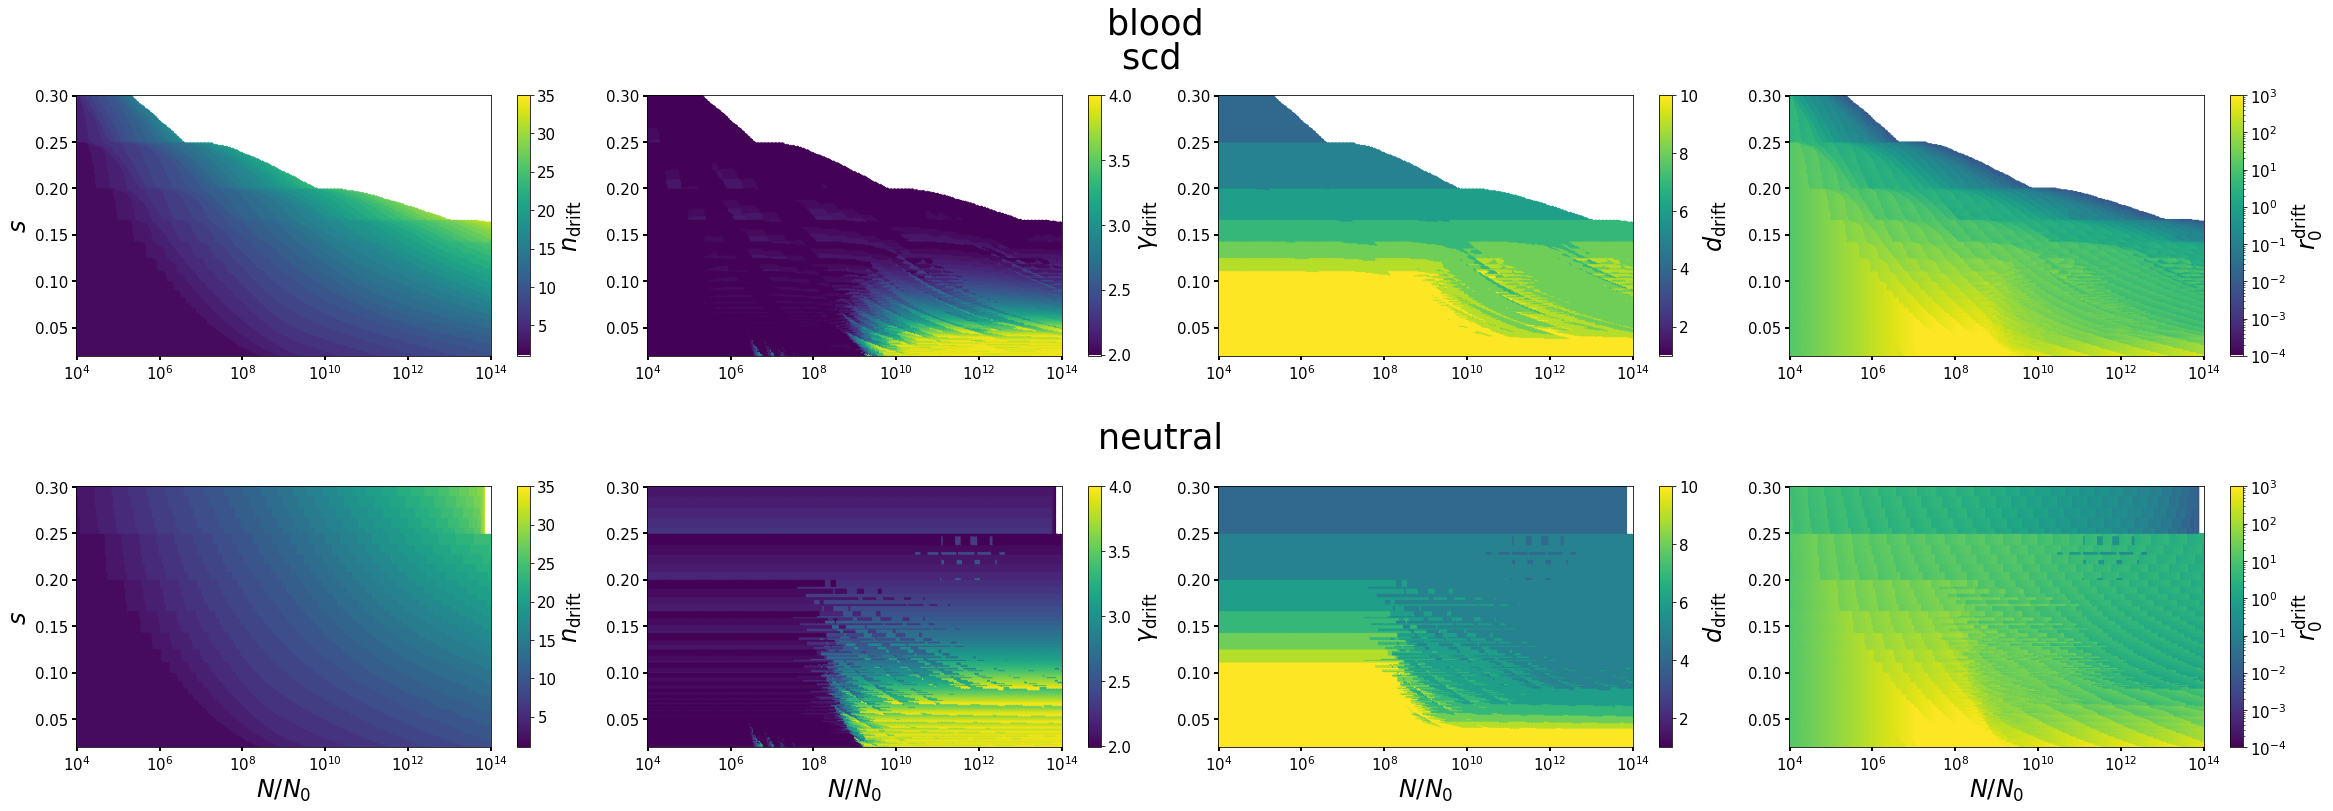

<ipython-input-18-636704e7ba70>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_relable)
<ipython-input-18-636704e7ba70>:41: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True)


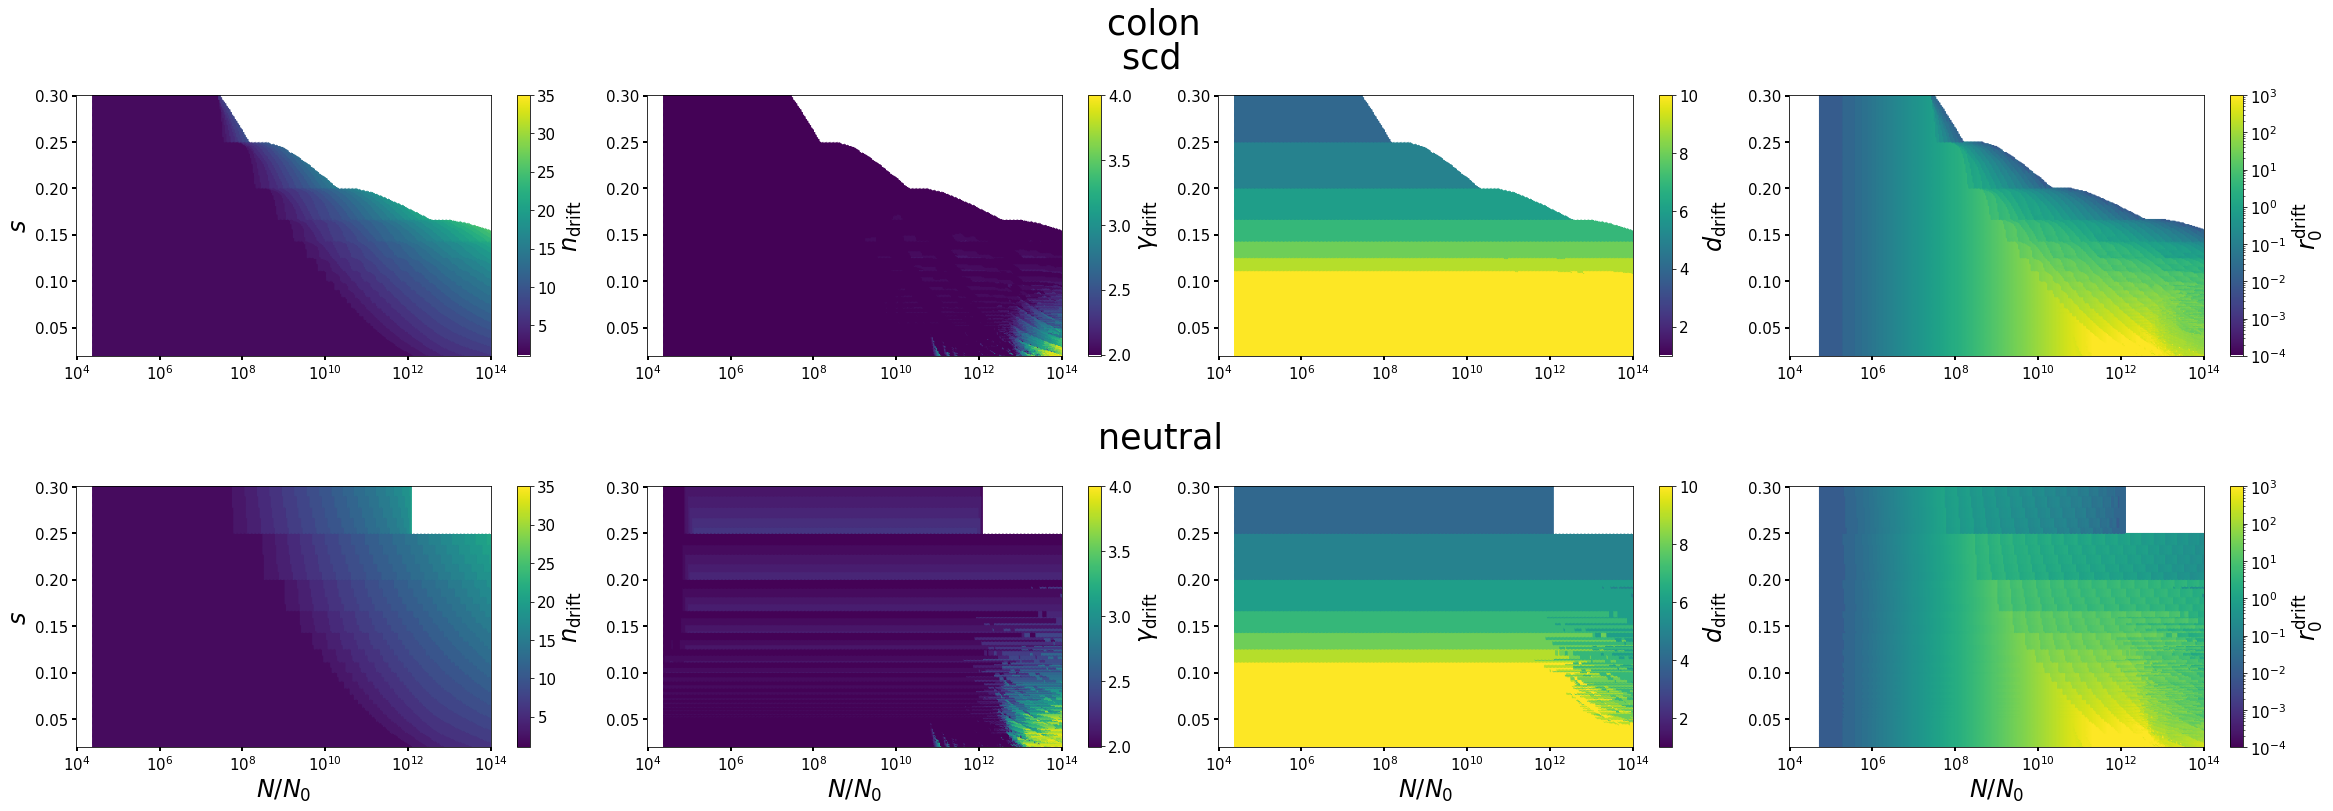

<ipython-input-18-636704e7ba70>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_relable)
<ipython-input-18-636704e7ba70>:41: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True)


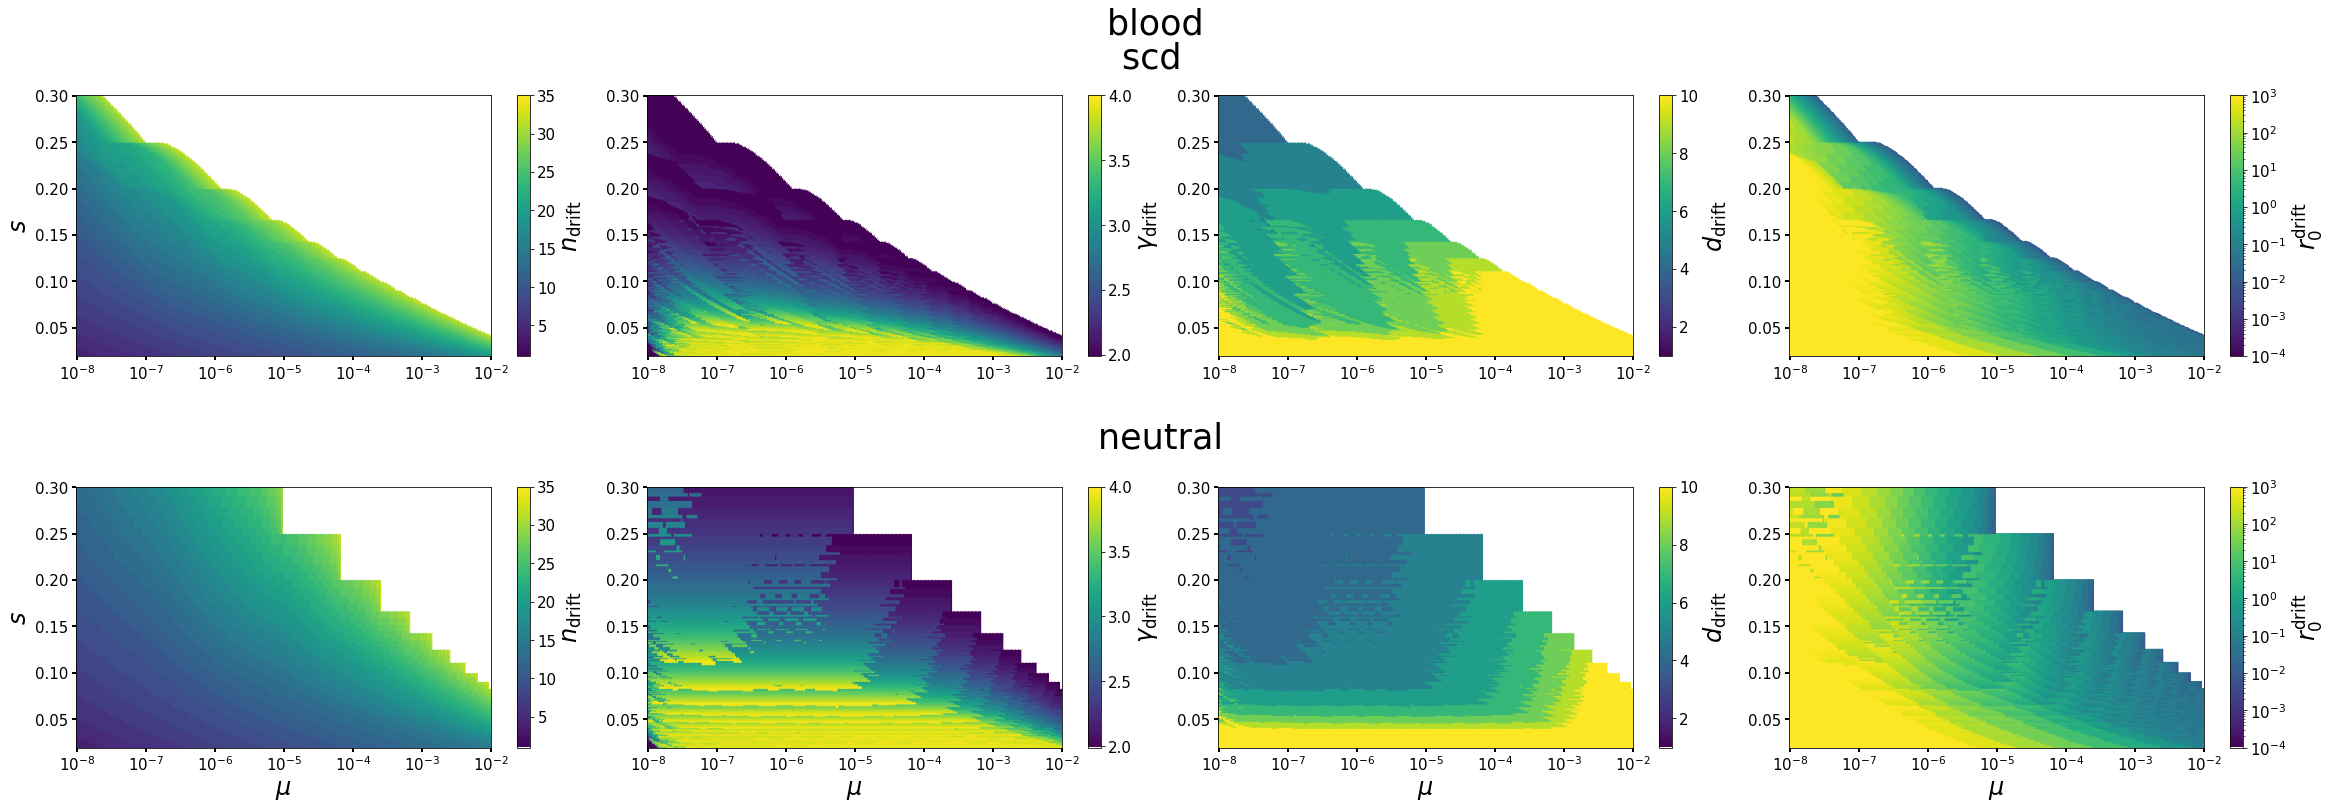

<ipython-input-18-636704e7ba70>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_relable)
<ipython-input-18-636704e7ba70>:41: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True)


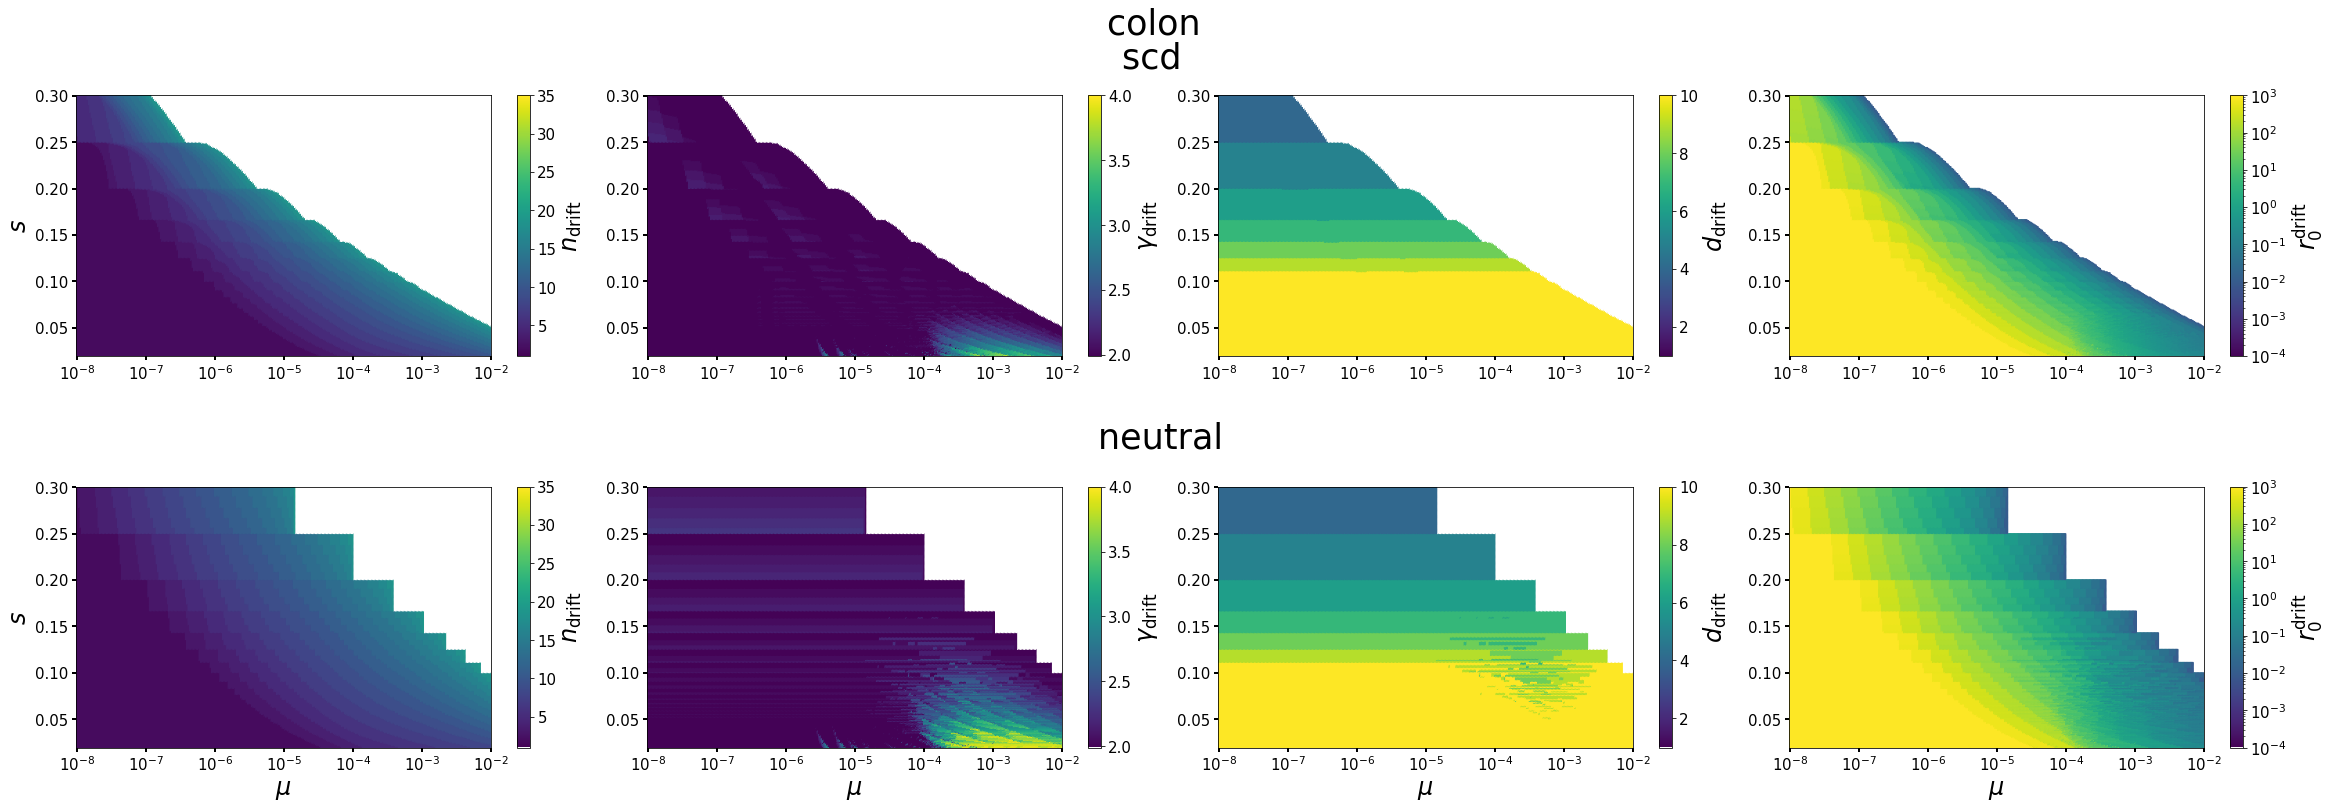

In [20]:
#hl_x_min,hl_x_max,hl_y_min,hl_y_max: 
#(hl_x_min,hl_ymin) : lower left corner of bounding box 
#(hl_x_max,hl_ymax) : upper right corner of bounding box
#       x
#(0,0)-------->
#   |                        (hl_x_max,hl_y_max)
#   |   +---------------------------+
# y |   :                           :
#   |   :                           :
#   |   :                           :
#   |   :                           :
#   V   :                           :
#       :                           :
#       +---------------------------+
# (hl_x_min,hl_y_min)
#                             
#            

hl_x_min,hl_x_max,hl_y_min,hl_y_max = 3,10,2,8

alphaval = 0.6

labels_size = 24 # X,Y,Z labels size

cb_ts = 15 # colorbar tick number font size

tick_ls = 15

title_s = 60 # size of title
im_w,im_h = 40,12  # image width and height
cb_scale = 4.8   # scale of colorbar font size
x_rot,y_rot = 90,0  # rotation of x and y tick labels

N01,N02 = 1e4,1e8

Xlabel = "$N/N_0$"
Ylabel = "$s$"

X1, Y1 = np.linspace(8, 18, RES), np.linspace(0.02,0.3,RES) # input axis for tisse #1
X2, Y2 = np.linspace(12, 22, RES), np.linspace(0.02,0.3,RES) # input axis for tisse #2


hl_x_min,hl_x_max,hl_y_min,hl_y_max = 1e8,1e14,0.1,0.2
HeatMapPlotter(X1,X2,Y1,Y2,N01,N02,inputData_N_s_b,Xlabel,Ylabel,"N_s_",0.7,im_w,im_h,"blood",hl_x_min,hl_x_max,hl_y_min,hl_y_max)
hl_x_min,hl_x_max,hl_y_min,hl_y_max = 1e8,1e16,0.1,0.2
HeatMapPlotter(X1,X2,Y1,Y2,N01,N02,inputData_N_s_c,Xlabel,Ylabel,"N_s_",0.7,im_w,im_h,"colon",hl_x_min,hl_x_max,hl_y_min,hl_y_max) 

#generate mu vs s plots


X1, Y1 = np.linspace(-2, -8, RES), np.linspace(0.02,0.3,RES)  # input axis for tisse #1
X2, Y2 = np.linspace(-2, -8, RES), np.linspace(0.02,0.3,RES) # input axis for tisse #2   


Xlabel = "$\mu$"
Ylabel = "$s$"

hl_x_min,hl_x_max,hl_y_min,hl_y_max = 1e-6,1e-4,0.1,0.3
HeatMapPlotter(X1,X2,Y1,Y2,N01,N02,inputData_mu_s_b,Xlabel,Ylabel,"mu_s_",0.7,im_w,im_h,"blood",hl_x_min,hl_x_max,hl_y_min,hl_y_max);

hl_x_min,hl_x_max,hl_y_min,hl_y_max = 1e-6,1e-4,0.1,0.2
HeatMapPlotter(X1,X2,Y1,Y2,N01,N02,inputData_mu_s_c,Xlabel,Ylabel,"mu_s_",0.7,im_w,im_h,"colon",hl_x_min,hl_x_max,hl_y_min,hl_y_max); 
